# **Predicting Red Wine Quality**
### **By Kristopher Agarwal**

---



## **Introduction**
Red wine is one of the most popular alcoholic beverages in the world, but also one of the most complex.  In the United States, from 2000 to 2021, wine consumption has gone up by over 50%, from 2.00 gallons per resident to 3.18 gallons.  The total amount of wine consumed in the US over that same time period has almost doubled.  With a global market valued at over $400 billion annually, and a projected annual growth rate of 6.4%, it is important to be able to accurately classify and quantify the quality of wine so that it can be priced accordingly.  There are many different factors that contribute to the quality of wine, including climate, weather, exposure to sunlight, and soil quality.  However, these systems are large and complex, and thus difficult to analyze.  Therefore, in this project, we will be looking at the way these factors manifest themselves: the chemical makeup of the wine itself.

The purpose of this project is to take you through the entire data science pipeline, starting with data curation, parsing, and management, and ending with the insights that we learned along the way.  The data from this project comes from the University of California Irvine's dataset on red wine samples taken from northern Portugal, and includes factors such as acidity, sugars, sulphates, alcohol content, and more.  The quality of the wines is measured on a scale of 0 (lowest quality wine) to 10 (highest quality wine).  We will be using this data to perform the k-Nearest Neighbors algorithm as well as Logistic Regression in order to be able to categorize the quality of wine into either high or low quality based on these chemical indicators.

---



## **Part 1: Data Curation, Parsing, and Management**



In this section, we are going to be collecting the data from its source and preparing it for analysis.  UC Irvine has already done much of this work for us and has organized it in a CSV file.  Our job is now to gather and parse that CSV file using Pandas DataFrames.  Since I am making this project in Google Colab, I first need to import the CSV file from my Google Drive so that I can use it.  If you are following along in another software, such as a Jupyter Notebook, you do not have to do this step. 

In [85]:
# upload the file so that it can be used in Google Colab
from google.colab import files
uploaded = files.upload()

Saving winequality-red.csv to winequality-red (2).csv


We now want to read our data from this CSV file into a Pandas DataFrame, so that we can continue with our analysis of the data.  If you are doing this outside of Google Colab, this is where you start.


In [86]:
# General imports, these will be used throughout the project
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import *
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from scipy import stats
import statsmodels.api as smf

In [87]:
# Read in data from CSV
df = pd.read_csv('winequality-red.csv', sep=';')
# Remove any NA values in the data that can mess up our analysis
df = df.dropna()
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


We also now want to remove any outliers that could mess with our model.  An outlier is defined as anything greater than Q3 + 1.5(IQR) or anything lower than Q1 - 1.5(IQR), where Q1 represents the first quartile (25th percentile), Q3 represents the third quartile (75th percentile) and IQR = Q3 - Q1.

In [88]:
# Calculate the 25th and 75th percentile of the column
Q1, Q3 = np.percentile(df['quality'], q=25), np.percentile(df['quality'], q=75) 

# Select and Calculate outlier range using interquartile range
outlier_range = 1.5 * (Q3 - Q1)

# Outliers in data
num_data = df[((df['quality'] < (Q1 - outlier_range)) | (df['quality'] > (Q3 + outlier_range)))].shape[0]

# Remove outliers
df = df[df['quality'] >= (Q1 - outlier_range)].reset_index(drop=True)
df = df[df['quality'] <= (Q3 + outlier_range)].reset_index(drop=True)

# Display number of outliers
print("Number of outliers removed: ", num_data)

Number of outliers removed:  28


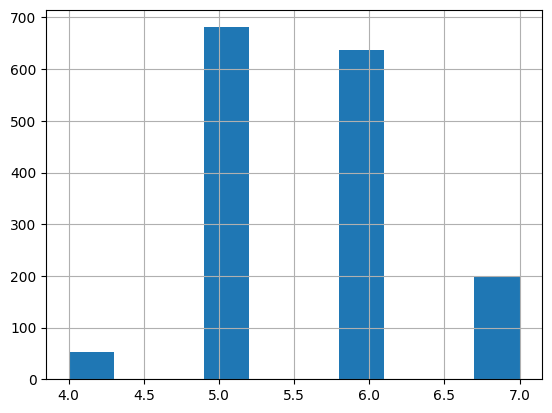

In [89]:
df['quality'].hist(bins=10)
plt.show()

A large majority of the data has a quality rating of either 5 or 6 with smaller proportions with a rating of 4 and 7.  In our classification, we will consider a wine with a quality less than or equal to 5 as a lower quality wine, and anything with a quality of 6 or above to be a higher quality wine.

This data appears to mostly be on different scales, so it will be helpful for us to standardize the data before doing any kind of regression analysis.  We will standardize using the formula:

(actual - mean) / standard deviation

This standardization formula will yield data as the number of standard deviations they are away from the mean.  Negative values indicate a lower value than the mean, and positive values indicate a higher value than the mean.

In [90]:
# Create new dataframe and fill it with standardized values
# Quality remains the same, as that is our dependent variable
stand_df = pd.DataFrame().reindex_like(df)
stand_df['fixed acidity'] = (df['fixed acidity'] - df['fixed acidity'].mean()) / df['fixed acidity'].std()
stand_df['volatile acidity'] = (df['volatile acidity'] - df['volatile acidity'].mean()) / df['volatile acidity'].std()
stand_df['citric acid'] = (df['citric acid'] - df['citric acid'].mean()) / df['citric acid'].std()
stand_df['residual sugar'] = (df['residual sugar'] - df['residual sugar'].mean()) / df['residual sugar'].std()
stand_df['chlorides'] = (df['chlorides'] - df['chlorides'].mean()) / df['chlorides'].std()
stand_df['free sulfur dioxide'] = (df['free sulfur dioxide'] - df['free sulfur dioxide'].mean()) / df['free sulfur dioxide'].std()
stand_df['total sulfur dioxide'] = (df['total sulfur dioxide'] - df['total sulfur dioxide'].mean()) / df['total sulfur dioxide'].std()
stand_df['density'] = (df['density'] - df['density'].mean()) / df['density'].std()
stand_df['pH'] = (df['pH'] - df['pH'].mean()) / df['pH'].std()
stand_df['sulphates'] = (df['sulphates'] - df['sulphates'].mean()) / df['sulphates'].std()
stand_df['alcohol'] = (df['alcohol'] - df['alcohol'].mean()) / df['alcohol'].std()
stand_df['quality'] = df['quality']
stand_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,-0.527578,0.986540,-1.393572,-0.451650,-0.243473,-0.472236,-0.386710,0.555203,1.294004,-0.573976,-0.959018,5
1,-0.297333,2.011501,-1.393572,0.044088,0.223867,0.867248,0.613849,0.021511,-0.722420,0.132790,-0.578006,5
2,-0.297333,1.328194,-1.187297,-0.168371,0.096410,-0.089526,0.219689,0.128249,-0.332144,-0.043901,-0.578006,5
3,1.659752,-1.405035,1.494280,-0.451650,-0.264716,0.101829,0.401609,0.661942,-0.982603,-0.456181,-0.578006,6
4,-0.527578,0.986540,-1.393572,-0.451650,-0.243473,-0.472236,-0.386710,0.555203,1.294004,-0.573976,-0.959018,5


We also want to set aside some data for testing and some for training.  One of the more commonly used testing/training splits is 80% for testing and 20% for training, so that is what we will use here.

In [91]:
train_df = stand_df.sample(frac=0.8, random_state=1)
x_train = np.array(train_df.iloc[:, :-1])
y_train = np.array(train_df['quality'])

# Select data for testing
data_test = stand_df.drop(train_df.index)
x_test = np.array(data_test.iloc[:, :-1])
y_test = np.array(data_test['quality'])

# Show number of training and testing data points
print("Number of Training data points: ", len(x_train))
print("Number of Testing data points: ", len(x_test))

Number of Training data points:  1257
Number of Testing data points:  314




---



## **Part 2: Exploratory Data Analysis**

In this section of the project, we are going to use visualization as well as statistical methods to determine the main characteristics of the data.  What this means in our case is that we are going to use linear regression to see if there are any data columns that are not correlated well with the quality of the wine.  These columns will be dropped and not used for further analysis since they do not correlate with quality.  We will make our regressions using the Scikit-Learn library and plot them with the Matplotlib library.  Since we are looking at the variables individually in this section, we will use the original values, not the standardized ones.

In [92]:
# dictionary to keep track of R^2 value for each column
cols = df.columns
cols = cols.drop('quality')
zeros = np.zeros(11)
r_sq_dict = {cols[i]:zeros[i] for i in range(len(zeros))}
print(r_sq_dict)

{'fixed acidity': 0.0, 'volatile acidity': 0.0, 'citric acid': 0.0, 'residual sugar': 0.0, 'chlorides': 0.0, 'free sulfur dioxide': 0.0, 'total sulfur dioxide': 0.0, 'density': 0.0, 'pH': 0.0, 'sulphates': 0.0, 'alcohol': 0.0}


In [93]:
def lin_regress(xcol):
  x = train_df[xcol].to_numpy().reshape(-1,1)
  y = train_df['quality']
  model = linear_model.LinearRegression().fit(x, y)
  # Coefficient of determination (r^2)
  r_sq = model.score(x, y)
  r_sq_dict[xcol] = r_sq
  print('R^2: ', r_sq)

  #predicted y values
  y_pred = model.predict(x)

  plt.scatter(x, y)
  plt.plot(x, y_pred, color='k')
  plt.xlabel(xcol)
  plt.ylabel("Quality")
  plt.title('%s vs Quality' % xcol)
  plt.show()

  print("Coefficient: ", model.coef_, "\nIntercept: ", model.intercept_)


R^2:  0.018129973592926896


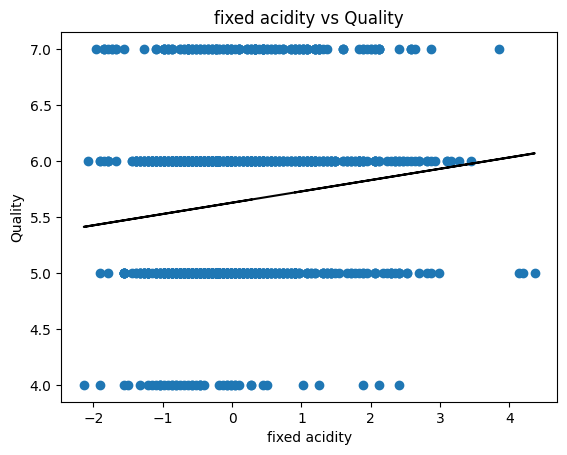

Coefficient:  [0.10097736] 
Intercept:  5.6271487311894095


In [94]:
# For fixed acidity
lin_regress('fixed acidity')

R^2:  0.14086709271190212


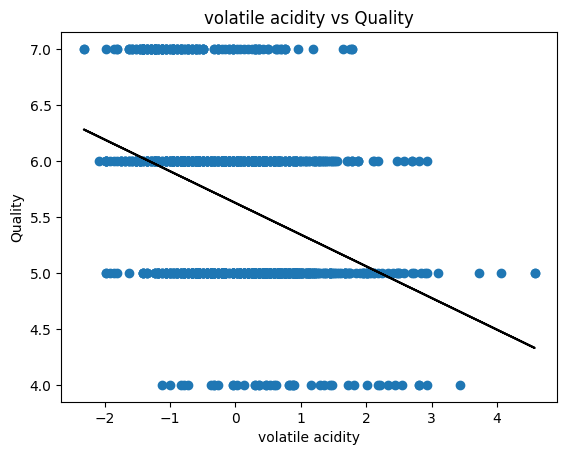

Coefficient:  [-0.28316643] 
Intercept:  5.625169047191926


In [95]:
# For volatile acidity
lin_regress('volatile acidity')

R^2:  0.04081728012236885


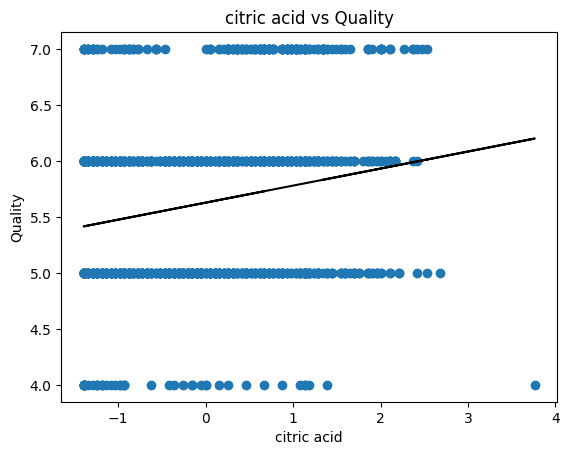

Coefficient:  [0.15207635] 
Intercept:  5.62765754209473


In [96]:
# For citric acid
lin_regress('citric acid')

R^2:  0.00012342781638219336


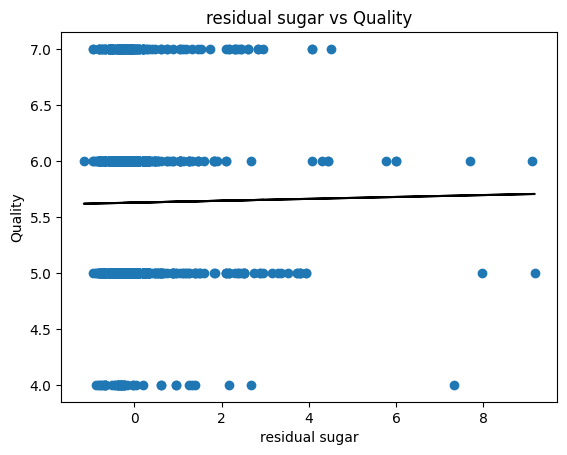

Coefficient:  [0.00842956] 
Intercept:  5.627648383496789


In [97]:
lin_regress('residual sugar')

R^2:  0.014187406485608789


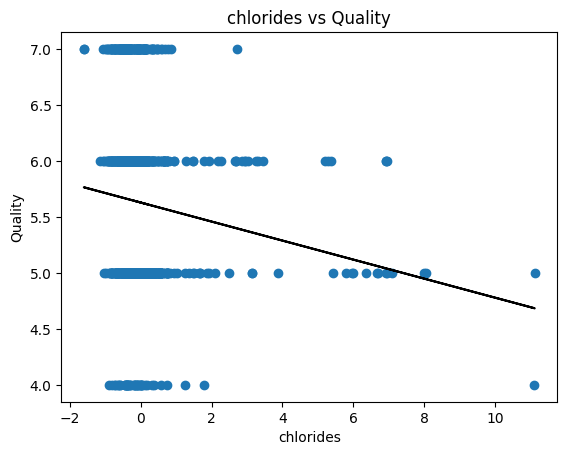

Coefficient:  [-0.08493422] 
Intercept:  5.628655127433259


In [98]:
lin_regress('chlorides')

R^2:  0.0027288797787569097


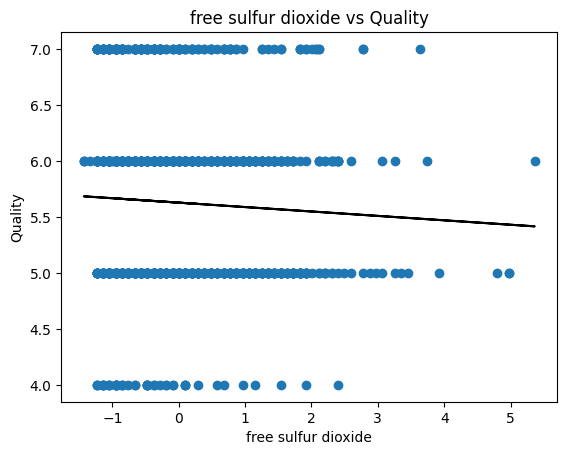

Coefficient:  [-0.03946206] 
Intercept:  5.627552240075563


In [99]:
lin_regress('free sulfur dioxide')

R^2:  0.039169848828769505


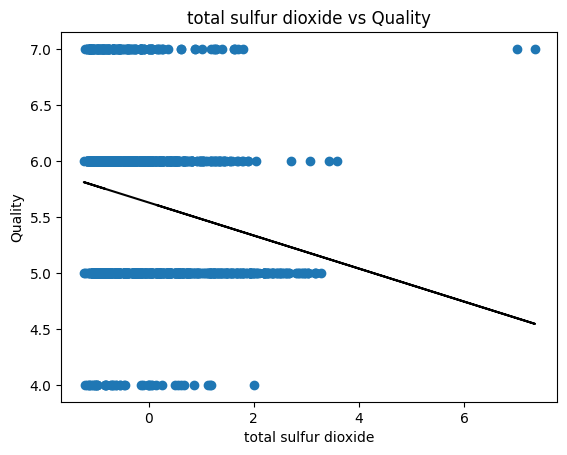

Coefficient:  [-0.14740916] 
Intercept:  5.628504002992089


In [100]:
lin_regress('total sulfur dioxide')

R^2:  0.02543478156154866


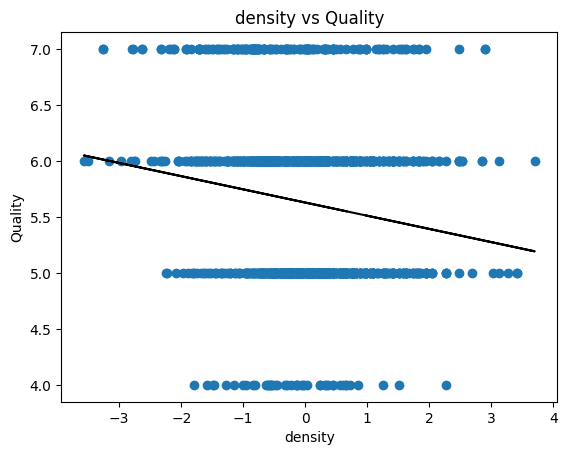

Coefficient:  [-0.11777523] 
Intercept:  5.6282352175103565


In [101]:
lin_regress('density')

R^2:  0.0012908273883955879


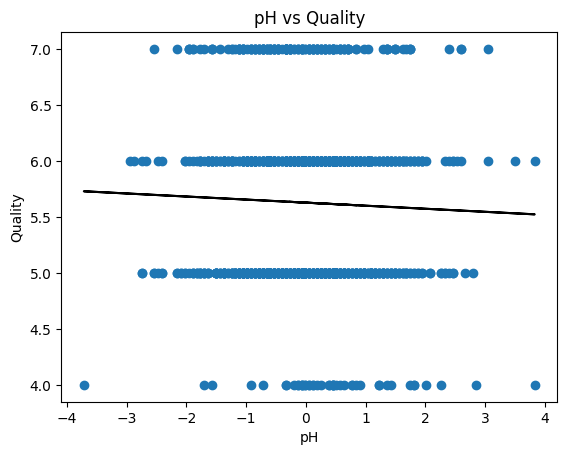

Coefficient:  [-0.02728653] 
Intercept:  5.627554183483021


In [102]:
lin_regress('pH')

R^2:  0.050016321120787466


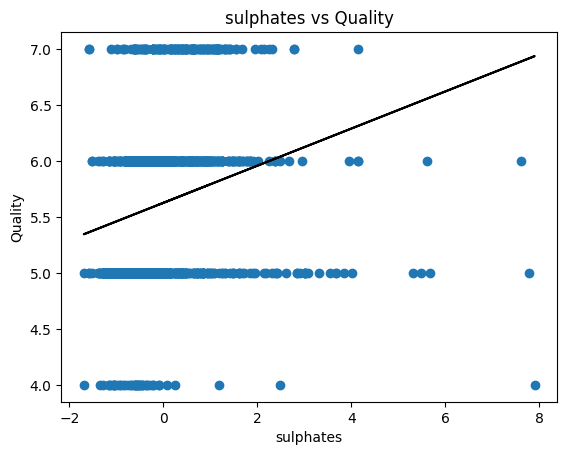

Coefficient:  [0.16568704] 
Intercept:  5.62568939481449


In [103]:
lin_regress('sulphates')

R^2:  0.2191981460989193


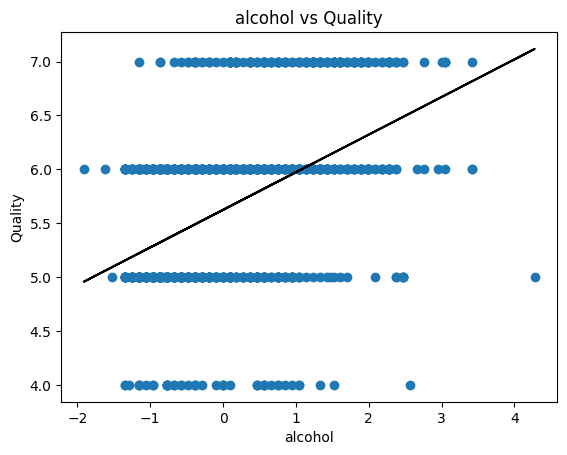

Coefficient:  [0.34889149] 
Intercept:  5.624369960107356


In [104]:
lin_regress('alcohol')

In [105]:
r_sq_ser = pd.Series(r_sq_dict)
r_sq_ser

fixed acidity           0.018130
volatile acidity        0.140867
citric acid             0.040817
residual sugar          0.000123
chlorides               0.014187
free sulfur dioxide     0.002729
total sulfur dioxide    0.039170
density                 0.025435
pH                      0.001291
sulphates               0.050016
alcohol                 0.219198
dtype: float64

In [106]:
r_sq_ser[r_sq_ser > 0.05]

volatile acidity    0.140867
sulphates           0.050016
alcohol             0.219198
dtype: float64

As seen from the R^2 values above, none of these factors appear to have a strong linear relationship with quality.  However, there are some values that are far too low.  Setting the minimum R^2 value to be included in the model at 0.05, we are left with **volatile acidity, sulphates, and alcohol** as the independent variables for us to consider.  

---



## **Part 3: Hypothesis Testing and Machine Learning**




In this portion of the project, we will focus on the creation of our k-Nearest Neighbors model.  This model creates a vector for each observation alongside its classification.  When a new datapoint is considered, the k observations that are closest to the new one are used in order to assign a classification to the new point.  In order to execute this algorithm, we need three things, our dataset, a distance metric, and a value for k.  The most common distance metric used in this algorithm is Euclidean distance 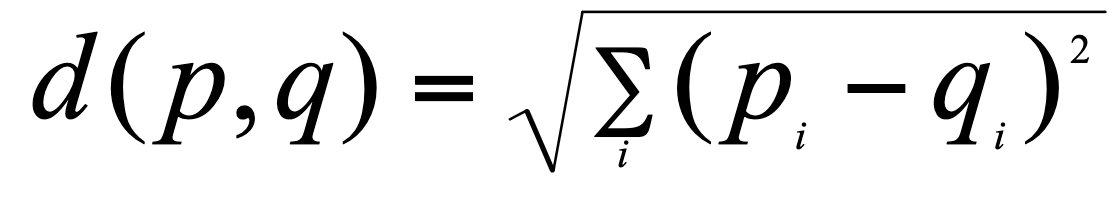

We also need to change our quality column so that it is categorical.  All lower quality wines (quality <= 5) will be labeled with 0, and all higher quality wines (quality >= 6) will be labeled with 1.  We will also do the same changes to the testing data.

In [107]:
train_df = train_df.drop(['fixed acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide',
                        'density', 'pH'], axis=1).reset_index(drop=True)
train_df.head()

,volatile acidity,sulphates,alcohol,quality
0,-0.721728,-0.102798,-1.149523,5
1,0.531002,0.014996,-0.578006,5
2,-0.437017,-0.515078,-0.673259,5
3,-0.437017,-0.220593,-0.863765,5
4,1.328194,-0.338387,1.041295,6


In [108]:
train_df['quality'] = 1 * (train_df['quality'] >= 6)
train_df.head()

,volatile acidity,sulphates,alcohol,quality
0,-0.721728,-0.102798,-1.149523,0
1,0.531002,0.014996,-0.578006,0
2,-0.437017,-0.515078,-0.673259,0
3,-0.437017,-0.220593,-0.863765,0
4,1.328194,-0.338387,1.041295,1


In [109]:
data_test = data_test.drop(['fixed acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide',
                        'density', 'pH'], axis=1).reset_index(drop=True)
data_test.head()

,volatile acidity,sulphates,alcohol,quality
0,0.531002,1.605220,-1.149523,5
1,-1.746689,-0.750667,-0.959018,6
2,-0.778670,-0.043901,-0.673259,5
3,-0.721728,-0.161695,-0.673259,6
4,-0.778670,-0.573976,-1.054270,5


In [110]:
data_test['quality'] = 1 * (data_test['quality'] >= 6)
data_test.head()

,volatile acidity,sulphates,alcohol,quality
0,0.531002,1.605220,-1.149523,0
1,-1.746689,-0.750667,-0.959018,1
2,-0.778670,-0.043901,-0.673259,0
3,-0.721728,-0.161695,-0.673259,1
4,-0.778670,-0.573976,-1.054270,0


In [111]:
y_train = 1 * (y_train >= 6)
y_test = 1 * (y_test >= 6)
print(y_train)
print(y_test)

[0 0 0 ... 0 0 1]
[0 1 0 1 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1
 1 1 0 0 0 1 0 1 0 0 0 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1
 1 1 0 0 0 1 1 1 1 0 0 0 1 1 0 1 1 1 0 0 1 0 0 1 1 0 0 1 0 1 1 0 1 0 1 1 1
 0 0 1 1 0 0 1 0 0 1 1 0 1 0 0 0 0 1 1 1 0 1 0 0 1 0 1 0 0 1 0 0 0 0 0 1 0
 0 0 1 0 0 0 0 0 1 1 0 0 0 0 1 0 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 0 0 1 1 0 1
 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 1 0 0 1 1 1 0 1 1 0 1 1
 1 1 1 0 0 1 0 0 0 0 1 1 1 1 0 1 1 1 0 1 1 0 1 1 1 1 1 1 0 1 1 0 0 0 0 0 1
 0 1 0 1 1 0 0 0 0 1 1 0 0 0 0 1 0 0 0 1 0 1 0 0 0 1 1 0 0 0 0 0 0 1 1 0 1
 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 0 0 1]


Now, it is time to actually implement the algorithm.  We will try out different k values with the testing data to try and optimize the k value.



In [112]:
# Given the training set and a test datapoint, and k, return 0 or 1
def kNN(train_x, train_y, test_x, k):
  # array of distances from test point to all training points
  distances = np.linalg.norm(train_x - test_x, axis=1)
  # k smallest distances
  nearest_neighbor_ids = distances.argsort()[:k]
  # get and return majority vote
  return stats.mode(train_y[nearest_neighbor_ids])

In [113]:
dict_correct = {}
for k in range(1, 21, 2):
  num_correct = 0
  num_wrong = 0
  for i in range(len(x_test)):
    classification = kNN(x_train, y_train, x_test[i], k)[0]
    if (classification == y_test[i]):
      num_correct += 1
    else:
      num_wrong += 1
  dict_correct[k] = (num_correct, num_wrong)

<ipython-input-112-c74f5cf06423>:8: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  return stats.mode(train_y[nearest_neighbor_ids])


In [114]:
print(dict_correct)

{1: (233, 81), 3: (226, 88), 5: (232, 82), 7: (234, 80), 9: (233, 81), 11: (234, 80), 13: (236, 78), 15: (237, 77), 17: (236, 78), 19: (229, 85)}


{1: 0.7420382165605095, 3: 0.7197452229299363, 5: 0.7388535031847133, 7: 0.7452229299363057, 9: 0.7420382165605095, 11: 0.7452229299363057, 13: 0.7515923566878981, 15: 0.7547770700636943, 17: 0.7515923566878981, 19: 0.7292993630573248}


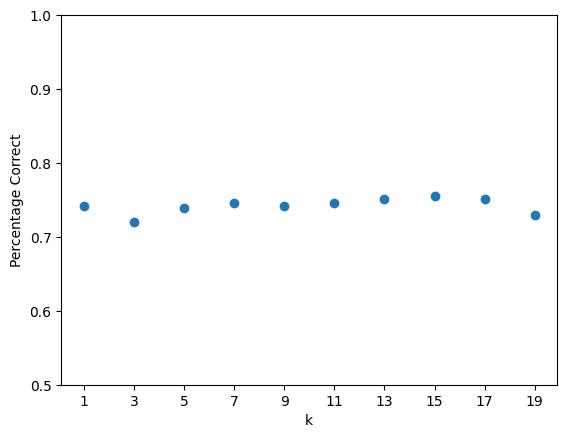

In [115]:
dict_pct_correct = {}
dict_mse = {}
for k in dict_correct:
  dict_pct_correct[k] = dict_correct[k][0] / (dict_correct[k][0] + dict_correct[k][1])
print(dict_pct_correct)
plt.scatter(dict_pct_correct.keys(), dict_pct_correct.values())
plt.ylim(0.5, 1)
plt.xticks(np.arange(1, 21, 2))
plt.xlabel('k')
plt.ylabel('Percentage Correct')
plt.show()

As we see above, the k-Nearest Neighbors model above, we are able to best classify wine quality with the k value of 15, yielding 75.48% accuracy.  Given that we only have two categories, this is not great accuracy.  Let's see if we can improve it.  We will also now calculate the Mean Squared Error (MSE) for each model.  Since it is a binary classification algorithm, for every correct value, MSE = 0, and for every incorrect value, MSE = 1.  
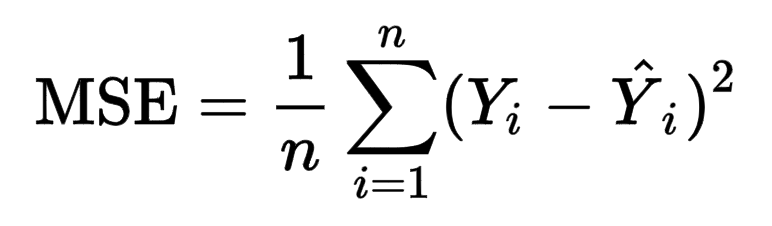

{1: 0.25796178343949044, 3: 0.2802547770700637, 5: 0.2611464968152866, 7: 0.25477707006369427, 9: 0.25796178343949044, 11: 0.25477707006369427, 13: 0.2484076433121019, 15: 0.24522292993630573, 17: 0.2484076433121019, 19: 0.27070063694267515}


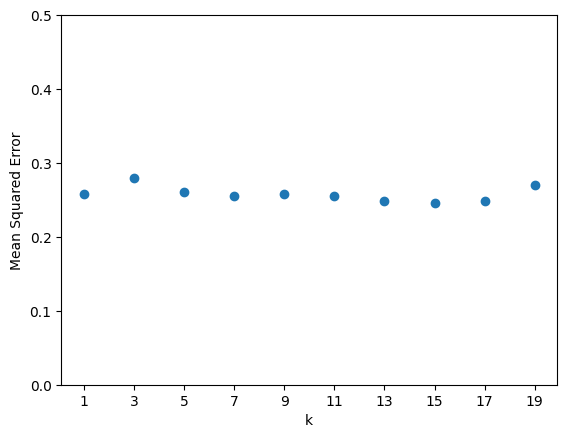

In [116]:
# Calculate MSE for each model
mse_dict = {}
for k in dict_correct:
  mse_dict[k] = dict_correct[k][1] / (dict_correct[k][0] + dict_correct[k][1])
print(mse_dict)
plt.scatter(mse_dict.keys(), mse_dict.values())
plt.xlabel('k')
plt.ylabel('Mean Squared Error')
plt.xticks(range(1, 21, 2))
plt.ylim(0, 0.5)
plt.show()

Now, since we did not have a very high accuracy with our own model, we will try with scikit-learn's k-Nearest Neighbors model since it is more optimized.  We can then compare the MSE of both models.

In [117]:
# import
from sklearn.neighbors import KNeighborsRegressor

{1: 0.25796178343949044, 3: 0.18895966029723996, 5: 0.17859872611464972, 7: 0.17541921227089563, 9: 0.17091295116772826, 11: 0.16810549034058006, 13: 0.16846945313383338, 15: 0.1742533616418967, 17: 0.17726401163687658, 19: 0.17811457910616302}


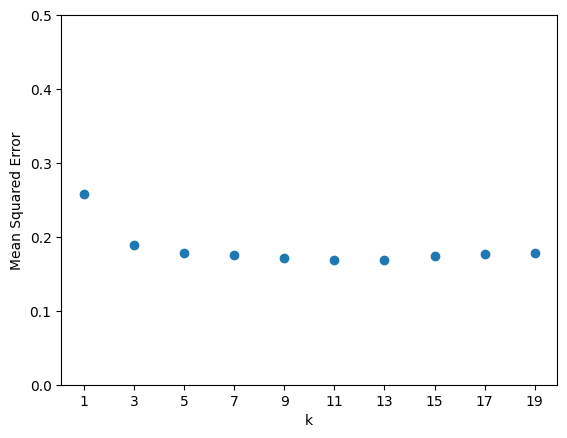

In [118]:
size = len(range(1, 21, 2))
knn_models = []
mse_dict = {}
for i in range(size):
  knn_models.append(KNeighborsRegressor(n_neighbors=(2 * i + 1)))
  knn_models[i].fit(x_train, y_train)
  y_pred = knn_models[i].predict(x_test)
  mse_dict[(2 * i) + 1] = mean_squared_error(y_test, y_pred)
print(mse_dict)

plt.scatter(mse_dict.keys(), mse_dict.values())
plt.xlabel('k')
plt.ylabel('Mean Squared Error')
plt.xticks(range(1, 21, 2))
plt.ylim(0, 0.5)
plt.show()

In the case of binary classification, MSE represents the inverse of the percentage correct (MSE = 1 - %correct).  Thus, at a lower MSE, more of the test data is correctly predicted.  This means that at k = 11, there was an accuracy of 83.19% (MSE = 0.1681 for k = 11), representing a roughly 8% increase in accuracy from the hand-coded model.

Another option for binary classification is the logistic regression, which computes the probability of an event occuring (in this case, a high quality wine) based on the feature values.  If this computed probability is found to be higher than 0.5, then the outputted value is 1, and vice versa.  We will be using StatsModels's Logistic Regression model here, and comparing the Mean Squared Error.  k-Nearest Neighbors is a non-linear model, and logistic regression is a linear model.  Thus, we can perform hypothesis tests alongside logistic regression in order to figure out if there is a correlation between our feature values and the quality of wine.  When performing these hypothesis tests, our null hypothesis is that there is no correlation between quality and our features.

In [119]:
# Need to add constant to the training data since StatsModels does not take intercept into account
x_train_new = smf.add_constant(x_train)
model = smf.Logit(y_train, x_train_new).fit()
model.params

Optimization terminated successfully.
         Current function value: 0.525232
         Iterations 6


array([ 0.20795289,  0.31556389, -0.60712414, -0.34149926,  0.02238995,
       -0.15015576,  0.2710041 , -0.54175279, -0.0445139 , -0.01947663,
        0.43199535,  0.88651583])

In [125]:
# predict for testing data
x_test_new = smf.add_constant(x_test)
# returns probabilities for each
y_pred = model.predict(x_test_new)
# convert probability to predictions (0 or 1)
y_pred = 1 * (y_pred > 0.5)

print('MSE: ', mean_squared_error(y_test, y_pred))

model.summary()

MSE:  0.24522292993630573


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 1257
Model:                          Logit   Df Residuals:                     1245
Method:                           MLE   Df Model:                           11
Date:                Tue, 09 May 2023   Pseudo R-squ.:                  0.2396
Time:                        21:18:28   Log-Likelihood:                -660.22
converged:                       True   LL-Null:                       -868.27
Covariance Type:            nonrobust   LLR p-value:                 2.315e-82
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2080      0.069      3.007      0.003       0.072       0.344
x1             0.3156      0.196      1.610      0.107      -0.069       0.700
x2            -0.6071      0.099     -6.152      0.000      -0.801      -0.414
x3            -0.3415      0.124     -2.756      0.006      -0.584      -0.099
x4             0.0224      0.086      0.259      0.796      -0.147       0.192
x5            -0.1502      0.080     -1.872      0.061      -0.307       0.007
x6             0.2710      0.097      2.795      0.005       0.081       0.461
x7            -0.5418      0.107     -5.073      0.000      -0.751      -0.332
x8            -0.0445      0.172     -0.259      0.796      -0.381       0.292
x9            -0.0195      0.127     -0.153      0.878      -0.269       0.230
x10            0.4320      0.084      5.156      0.000       0.268       0.596
x11            0.8865      0.123      7.202      0.000       0.645       1.128
==============================================================================
"""

Our logistic regression yielded an MSE of 0.2452, which is higher than the error for the sklearn kNN model, and similar to the values from our own model.  As seen in the summary above, this model achieved a p-value of 2.315e-832, which is significantly lower than 0.05, our cutoff to reject the null hypothesis.  P-values represent the probability that, assuming the null hypothesis to be true, we would obtain a result as extreme or more extreme than the one found in the data.  Since we have a very low p-value, we are able to reject the null hypothesis, and we have found a statistically significant relationship between the feature values and wine quality.


---



## **Part 4: Insights and Interpretation**

In this project, we analyzed UC Irvine's dataset on red wine quality in order to classify wine as either higher or lower quality.  The feature values that we made use of for our models are volatile acidity, sulphates, and alcohol content.  We utilized two different methods to do this: k-Nearest Neighbors and logistic regression.  Within our two attempts at k-Nearest Neighbors, one using a hand-coded version of the algorithm and one with the sklearn library, which performed roughly 8% better than our own version.  

The logistic regression performed around the same as our own version of kNN, and in doing so, we were able to establish a significantly significant relationship between our features and wine quality.  With that being said, our logistic regression model did perform worse than the sklearn kNN model, which was able to achieve over 80% accuracy.

The relationship that we established in this project may prove useful to wine producers, as wine is priced primarily on quality.  Thus, being able to identify the quality of wine using quantitative measures as opposed to the subjective measure of taste could prove useful.  Perhaps, more models like these could be developed in the future in order to create better, more accurate pricing models for producers, stores, and restaurants.  As this industry continues to grow, producers will look for ways to get an edge over others, and models like this may provide that edge in the future.


---



## **Bibliography:**

**Data Source:**

[University of California Irvine Wine Quality Dataset](https://archive.ics.uci.edu/ml/datasets/wine+quality)


**Information Sources:**

[US Wine Consumption Data](https://wineinstitute.org/our-industry/statistics/us-wine-consumption/)

[Wine Market Size, Share & Trends Analysis Report](https://www.grandviewresearch.com/industry-analysis/wine-market#:~:text=The%20global%20wine%20market%20size,key%20factor%20for%20market%20growth)

[P-Value Information](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4111019/#:~:text=The%20P%20value%20is%20defined,groups%20is%20due%20to%20chance)

[Hypothesis Testing with Logistic Regression](https://www.statology.org/null-hypothesis-of-logistic-regression/)


**Helpful Links:**

[k-Nearest Neighbors](https://www.ibm.com/topics/knn#:~:text=The%20k%2Dnearest%20neighbors%20algorithm%2C%20also%20known%20as%20KNN%20or,of%20an%20individual%20data%20point.)

[Logistic Regression](https://www.ibm.com/topics/logistic-regression#:~:text=Resources-,What%20is%20logistic%20regression%3F,given%20dataset%20of%20independent%20variables.)

[Classification Algorithms](https://towardsdatascience.com/top-machine-learning-algorithms-for-classification-2197870ff501)

[Prediction Models](https://www.netsuite.com/portal/resource/articles/financial-management/predictive-modeling.shtml)